In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor


ROOT = Path(os.getcwd()).parents[0]
ROOT

PosixPath('/Users/dantrainer/projects/cancer_research')

In [2]:
DATA_PATH = os.path.join(ROOT, 'data', 'TCGA-BRCA.star_fpkm-uq.tsv')
CLINICAL_DATA_PATH = os.path.join(ROOT, 'data', 'TCGA-BRCA.clinical.tsv')

In [3]:
df = pd.read_csv(DATA_PATH, sep='\t', index_col=0).drop_duplicates()
df_clinical = pd.read_csv(CLINICAL_DATA_PATH, sep='\t', index_col=0).drop_duplicates()

display(df.head())
print(f"Number of genes: {df.shape[0]}")
print(f"Number of samples: {df.shape[1]}")
display(df_clinical.head())
print(f"Number of clinical samples: {df_clinical.shape[0]}")
print(f"Number of clinical features: {df_clinical.shape[1]}")

,TCGA-D8-A146-01A,TCGA-AQ-A0Y5-01A,TCGA-C8-A274-01A,TCGA-BH-A0BD-01A,TCGA-B6-A1KC-01B,TCGA-AC-A62V-01A,TCGA-AO-A0J5-01A,TCGA-BH-A0B1-01A,TCGA-A2-A0YM-01A,TCGA-AO-A03N-01B,...,TCGA-E2-A1IG-01A,TCGA-E9-A1NA-01A,TCGA-D8-A1JP-01A,TCGA-AR-A252-01A,TCGA-D8-A1XL-01A,TCGA-BH-A0EI-01A,TCGA-E2-A1IO-01A,TCGA-E2-A15R-01A,TCGA-B6-A0IP-01A,TCGA-A1-A0SN-01A
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.767708,2.132741,4.768010,3.049735,3.009311,2.262163,2.929999,4.243105,4.231540,3.126461,...,3.083077,2.463256,3.263365,3.203264,3.653874,4.470745,4.214863,1.175109,5.008083,1.993783
ENSG00000000005.6,1.759454,0.146003,0.000000,1.071763,0.185993,0.308594,0.467071,0.121281,0.124196,0.000000,...,0.038015,0.045024,0.023184,1.922426,0.000000,0.104739,0.224658,0.127501,0.165172,0.015783
ENSG00000000419.13,4.920541,5.284151,5.051694,4.618797,4.852973,5.364065,3.958935,5.171995,4.771500,5.550193,...,4.556411,4.596321,5.213518,4.374831,5.696970,5.234413,4.876325,4.975405,4.569892,6.213147
ENSG00000000457.14,2.612588,2.428544,3.356299,2.680774,2.381671,1.128095,2.787265,2.398214,1.637378,1.876527,...,2.257493,2.141498,3.250295,2.203232,2.196827,2.030407,2.303109,2.895225,2.681697,2.431356
ENSG00000000460.17,1.363395,1.158337,2.458172,2.494236,1.565841,1.249809,1.221939,1.857344,2.197771,1.396050,...,1.223670,1.222805,2.184534,1.291250,1.736778,1.531219,1.123070,1.955015,1.791314,1.716025


Number of genes: 58049
Number of samples: 1226


,id,disease_type,case_id,submitter_id,primary_site,alcohol_history.exposures,race.demographic,gender.demographic,ethnicity.demographic,vital_status.demographic,...,days_to_collection.samples,initial_weight.samples,preservation_method.samples,pathology_report_uuid.samples,oct_embedded.samples,specimen_type.samples,days_to_sample_procurement.samples,is_ffpe.samples,tissue_type.samples,annotations.samples
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-BH-A0W3-01A,3c612e12-6de8-44fa-a095-805c45474821,Ductal and Lobular Neoplasms,3c612e12-6de8-44fa-a095-805c45474821,TCGA-BH-A0W3,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,85.0,120.0,OCT,801A4E2F-E26E-424F-BF42-CD0D9CD62BCE,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-AR-A24V-01A,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,Ductal and Lobular Neoplasms,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,TCGA-AR-A24V,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,1720.0,400.0,OCT,468CD293-C9F7-43C6-A40A-18FCDD22F6AA,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-01A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,280.0,OCT,CF6E29A2-FAE6-45BB-B625-33877887A89E,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-11A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,830.0,OCT,NaN,True,Solid Tissue,NaN,False,Normal,NaN
TCGA-AC-A8OQ-01A,dfaabd03-2d40-4422-b210-caf112ff4229,Ductal and Lobular Neoplasms,dfaabd03-2d40-4422-b210-caf112ff4229,TCGA-AC-A8OQ,Breast,Not Reported,black or african american,female,not hispanic or latino,Alive,...,742.0,100.0,Unknown,FFA6F9F3-71C1-4AF9-B9F7-0466550EBC90,False,Solid Tissue,NaN,False,Tumor,NaN


Number of clinical samples: 1255
Number of clinical features: 84


## Estimate the Survival Function using Kaplan-Meier

Here, the `days_to_death.demographic` columns represent the days from initial diagnosis to death. This represents the time value for patients who had the event. The `days_to_last_follow_up.diagnosis` column represents the number of days from initial diagnosis to the last known follow up appointment, representing the time value for patients who are censored.

In [4]:
df_clinical[["days_to_death.demographic", "days_to_last_follow_up.diagnoses"]]

,days_to_death.demographic,days_to_last_follow_up.diagnoses
sample,,
TCGA-BH-A0W3-01A,NaN,728.0
TCGA-AR-A24V-01A,NaN,3203.0
TCGA-E9-A1NE-01A,NaN,1088.0
TCGA-E9-A1NE-11A,NaN,1088.0
TCGA-AC-A8OQ-01A,NaN,34.0
...,...,...
TCGA-BH-A1FH-11B,1034.0,NaN
TCGA-BH-A1FH-01A,1034.0,NaN
TCGA-AR-A1AO-01A,NaN,2618.0


Create an event and duration column following the standard Kaplan-Meier conventions.

In [5]:
df_clinical["event"] = df_clinical["days_to_last_follow_up.diagnoses"].isna().astype(int)
df_clinical["duration"] = df_clinical.apply(
    lambda x: x["days_to_death.demographic"] if x["event"] else x["days_to_last_follow_up.diagnoses"], 
    axis=1
    )
df_clinical["duration"] = df_clinical["duration"]/365  # Convert to years
df_clinical = df_clinical[df_clinical["duration"]>=0] # Remove negative durations
df_clinical[["event", "duration"]]

,event,duration
sample,,
TCGA-BH-A0W3-01A,0,1.994521
TCGA-AR-A24V-01A,0,8.775342
TCGA-E9-A1NE-01A,0,2.980822
TCGA-E9-A1NE-11A,0,2.980822
TCGA-AC-A8OQ-01A,0,0.093151
...,...,...
TCGA-BH-A1FH-11B,1,2.832877
TCGA-BH-A1FH-01A,1,2.832877
TCGA-AR-A1AO-01A,0,7.172603


Text(0.5, 1.0, 'Distribution of survival duration in TCGA-BRCA dataset')

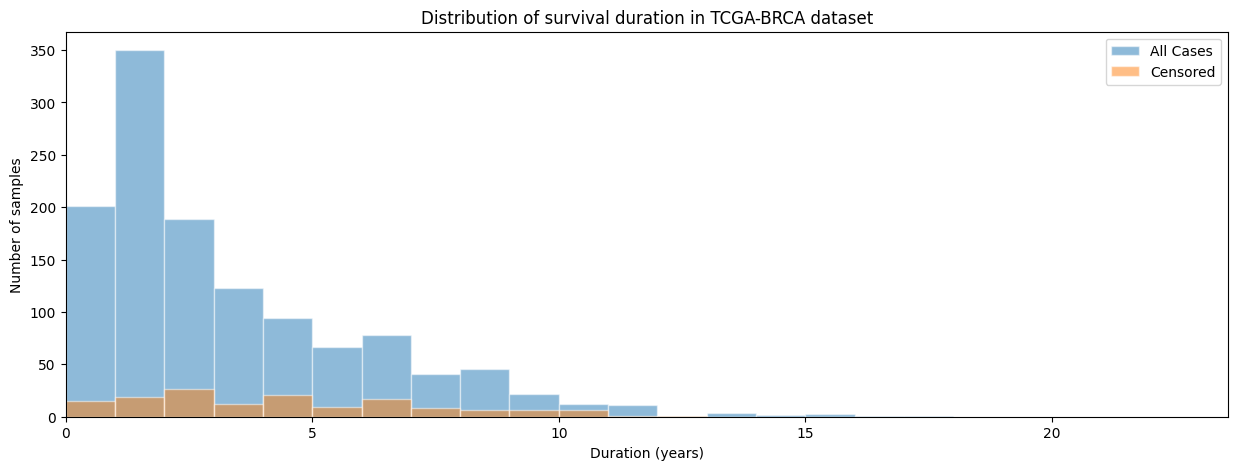

In [6]:
_, axes = plt.subplots(figsize=(15,5))

plt.hist(
    df_clinical["duration"], 
    bins=np.arange(0, 20, 1),
    alpha=0.5,
    label='All Cases',
    edgecolor='w'
)
plt.hist(
    df_clinical[df_clinical["event"]==1]["duration"], 
    bins=np.arange(0, 20, 1),
    alpha=0.5,
    label='Censored',
    edgecolor='w'
)
plt.xlim(0, df_clinical["duration"].max())
plt.xlabel("Duration (years)")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Distribution of survival duration in TCGA-BRCA dataset")

(0.0, 1.0)

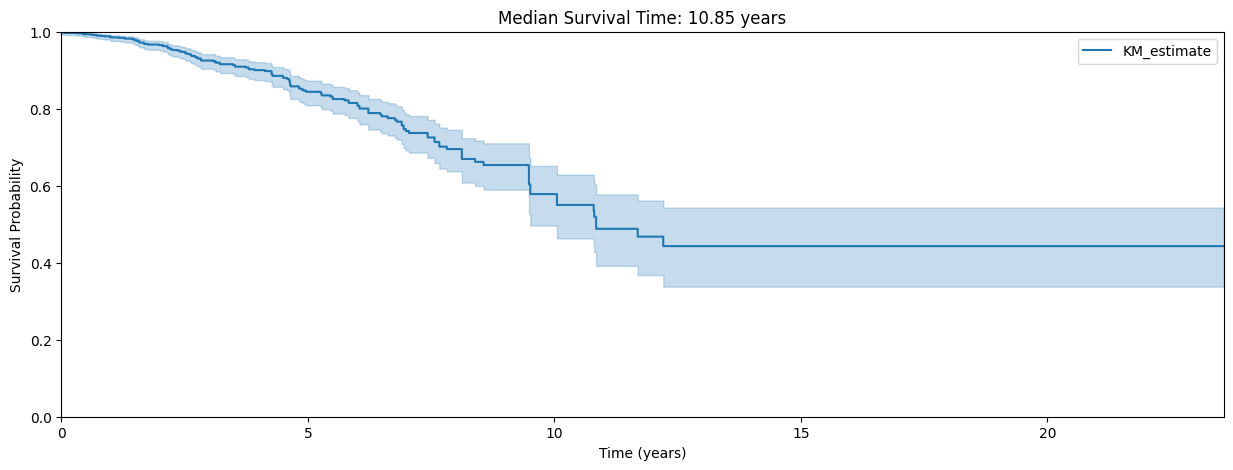

In [7]:
kmf = KaplanMeierFitter()

df_clinical = df_clinical.dropna(subset=["event", "duration"])
kmf.fit(df_clinical["duration"], event_observed=df_clinical["event"])

_, axes = plt.subplots(figsize=(15,5))
kmf.plot_survival_function()
plt.title(f"Median Survival Time: {kmf.median_survival_time_:.2f} years")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1)

In this specific dataset, after 12 years of follow-up, no further deaths were observed. About 45% of the patients in this cohort survived for at least 12 years, at which point we no longer have complete information - perhaps theon the study period ended.

## Analyze Survival Time vs. ESR1 Expression

In [8]:
ESR1_Ensembl_ID = 'ENSG00000091831'

df.index = [id_.split('.')[0] for id_ in df.index]
esr_expression = df.loc[ESR1_Ensembl_ID]

Text(0, 0.5, 'Frequency')

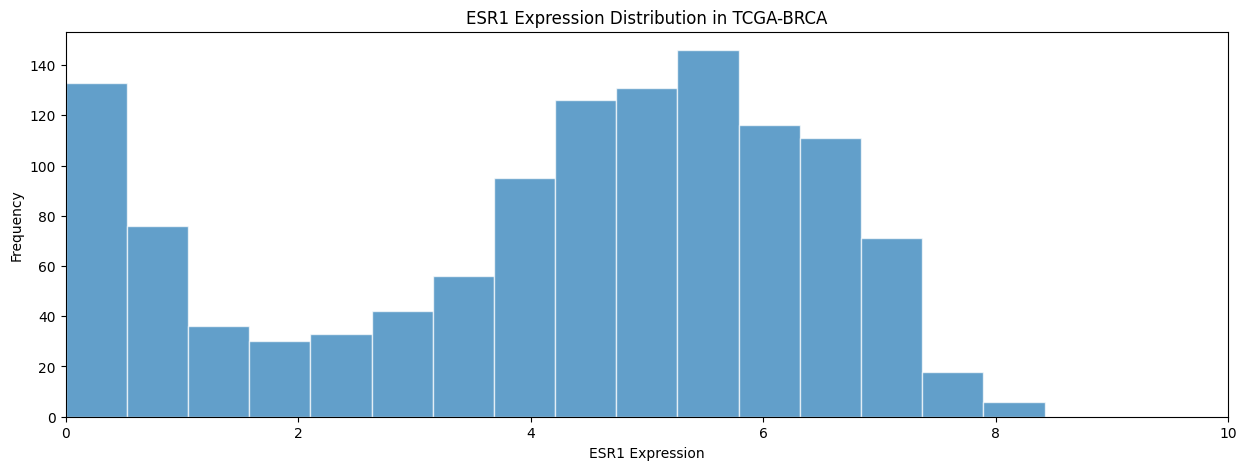

In [9]:
_, axes = plt.subplots(figsize=(15, 5))

axes.hist(
    esr_expression,
    bins=np.linspace(0, 10, 20),
    edgecolor='white',
    alpha=0.7,
    )

axes.set_xlim(0, 10)

plt.title('ESR1 Expression Distribution in TCGA-BRCA')
plt.xlabel('ESR1 Expression')
plt.ylabel('Frequency')

Merge ESR1 with Clinical Data

In [10]:
df_clinical = df_clinical.merge(esr_expression, left_index=True, right_index=True) 

In [11]:
above_median_expression = df_clinical[ESR1_Ensembl_ID] > esr_expression.median()

In [12]:
results = logrank_test(
    durations_A = df_clinical[~above_median_expression]['duration'],
    event_observed_A = df_clinical[~above_median_expression]['event'],
    label_A = 'Low ESR1 Expression',

    durations_B = df_clinical[above_median_expression]['duration'],
    event_observed_B = df_clinical[above_median_expression]['event'],
    label_B = 'High ESR1 Expression'
)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
           label_A = Low ESR1 Expression
           label_B = High ESR1 Expression
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.81 0.18      2.48

(0.0, 1.0)

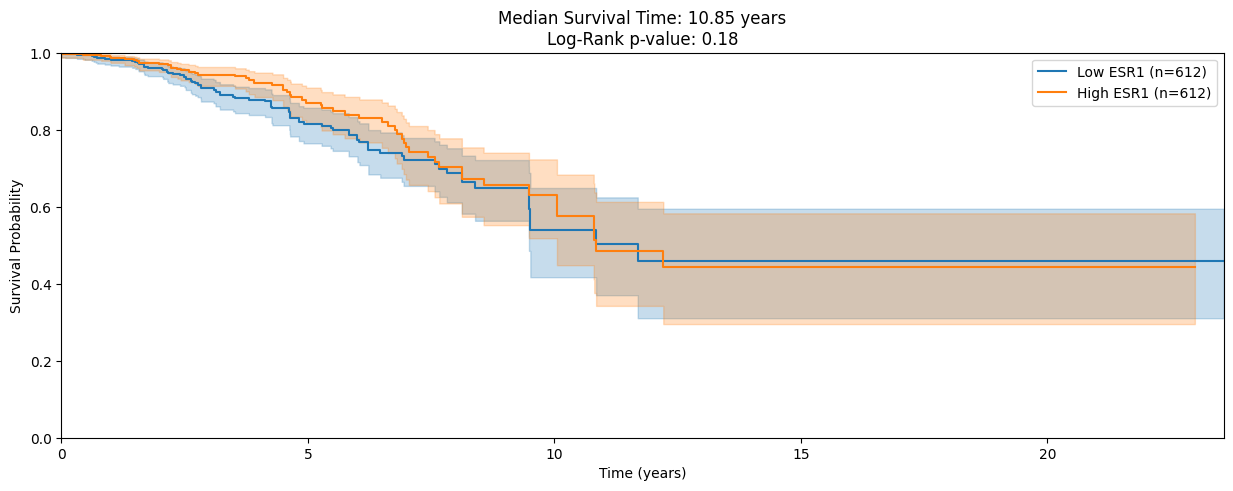

In [13]:
kmf = KaplanMeierFitter()

df_clinical = df_clinical.dropna(subset=["event", "duration"])
kmf.fit(
    df_clinical[~above_median_expression]["duration"], 
    event_observed=df_clinical[~above_median_expression]["event"],
    label='Low ESR1 (n=%d)' % df_clinical[~above_median_expression].shape[0]
    )

_, axes = plt.subplots(figsize=(15,5))
kmf.plot_survival_function(ax = axes)

kmf.fit(
    df_clinical[above_median_expression]["duration"], 
    event_observed=df_clinical[above_median_expression]["event"],
    label='High ESR1 (n=%d)' % df_clinical[above_median_expression].shape[0]
    )

kmf.plot_survival_function(ax = axes)
plt.title(f"Median Survival Time: {kmf.median_survival_time_:.2f} years\nLog-Rank p-value: {results.p_value:.2f}")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1)

The p-value indicates that there is no statistical significance between the "High" vs. "Low" ESR1 groups

## Cox Regression to Predict Survival

Determine what columns to use to fit the model

Focus on a few columns for fitting to a Cox proportional hazard model

In [14]:
df_clinical["race.demographic"].value_counts(normalize=True)

race.demographic
white                               0.715686
black or african american           0.154412
not reported                        0.078431
asian                               0.050654
american indian or alaska native    0.000817
Name: proportion, dtype: float64

In [15]:
cols_to_check = [
    # 'alcohol_history.exposures', # alcohol history is Not Reported for all samples
    'race.demographic', 
    'age_at_index.demographic',
    ESR1_Ensembl_ID
]

data_x = df_clinical[["event", "duration"] + cols_to_check]
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(data_x[['race.demographic']])

one_hot_df = pd.DataFrame(
    one_hot_encoded.toarray(), 
    columns=encoder.get_feature_names_out(['race.demographic']),
    index = data_x.index
    )
data_x = pd.concat([data_x, one_hot_df], axis=1)

# # Optionally, drop the original categorical column
data_x.drop(
    columns=[
        'race.demographic', 
        'race.demographic_white', # remove white as the reference group
        'race.demographic_american indian or alaska native', #remove american indian or alaska native because it has very few samples 
        ], inplace=True)

data_x.head()

,event,duration,age_at_index.demographic,ENSG00000091831,race.demographic_asian,race.demographic_black or african american,race.demographic_not reported
TCGA-BH-A0W3-01A,0,1.994521,58.0,6.923400,0.0,0.0,0.0
TCGA-AR-A24V-01A,0,8.775342,52.0,4.742303,0.0,0.0,0.0
TCGA-E9-A1NE-01A,0,2.980822,28.0,4.296817,0.0,0.0,0.0
TCGA-AC-A8OQ-01A,0,0.093151,72.0,0.615981,0.0,1.0,0.0
TCGA-AC-A23C-01A,0,1.602740,62.0,6.677587,0.0,0.0,0.0


In [16]:
data_y = data_x[[ "event", "duration"]].copy()

data_y["event"] = data_y["event"].astype(bool)
data_y["duration"] = data_y["duration"]

tuple_list = [tuple(row) for row in data_y.itertuples(index=False, name=None)]

structured_dtype = np.dtype([('Status', '?'), ('Survival_in_days', '<f8')])
data_y = np.array([tuple(row) for row in data_y.to_numpy()], dtype=structured_dtype)
data_y

array([(False, 1.99452055), (False, 8.77534247), (False, 2.98082192), ...,
       (False, 7.17260274), (False, 3.12054795), (False, 3.12054795)],
      shape=(1224,), dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

Check for multi-coliniearity between features

In [17]:
X = data_x.drop(columns=["event", "duration"])
vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)
print(vif)

age_at_index.demographic                      5.484976
ENSG00000091831                               4.933163
race.demographic_asian                        1.055942
race.demographic_black or african american    1.216666
race.demographic_not reported                 1.128261
dtype: float64


Train the Cox Proportional Hazard model (from sk-survival) and determine the Hazard Ratios for each feature

In [18]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x.drop(columns = ["event", "duration"]), data_y)
pd.concat([
    pd.Series(estimator.coef_, index=data_x.drop(columns = ["event", "duration"]).columns).rename("Coefficients").round(3), 
    pd.Series(np.exp(estimator.coef_), index=data_x.drop(columns = ["event", "duration"]).columns).rename("Hazard Ratios").round(3), 
], axis=1)


,Coefficients,Hazard Ratios
age_at_index.demographic,0.037,1.038
ENSG00000091831,-0.099,0.905
race.demographic_asian,-1.004,0.367
race.demographic_black or african american,-0.374,0.688
race.demographic_not reported,-0.058,0.944


Takeaways from this model:
- Older folks are more likely to die, ie for every year increase in age, the patients risk of death increases by 3.8%
- The ESR1 Gene appears to be somewhat protective where for every unit increase in expression, the risk of death decreases by almost 10%
- The risk of death for a patient identified as black or african american is 31% lower than their white counterpart
- Interestingly, the asian population has the highest comparitive decrease in the inicidence of death however this subgroup comprises only 5% of the population. Check this result by calculating the p-value.

Use lifelines library to determine the p-value for the asian demographic coefficient to determine statistical significance of each feature.

In [19]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(data_x, duration_col='duration', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1224 total observations, 1080 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1224
number of events observed = 144
   partial log-likelihood = -815.28
         time fit was run = 2025-06-22 18:42:48 UTC

---
                                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                   
age_at_index.demographic                    0.04      1.04      0.01            0.02            0.05                1.02                1.05
ENSG00000091831                            -0.10      0.91      0.04           -0.18           -0.02                0.84                0.98
race.demographic_asian                     -1.00      0.37      1.01           -2.98            0.97                0.05                2.64
race.demographic_black or african american -0.37      0.69      0.24           -0.85            0.11                0.43                1.11
race.demographic_not reported              -0.06      0.94      0.46           -0.97            0.85                0.38                2.34

                                            cmp to     z      p  -log2(p)
covariate                                                                
age_at_index.demographic                      0.00  5.37 <0.005     23.62
ENSG00000091831                               0.00 -2.46   0.01      6.15
race.demographic_asian                        0.00 -1.00   0.32      1.65
race.demographic_black or african american    0.00 -1.53   0.13      2.98
race.demographic_not reported                 0.00 -0.13   0.90      0.15
---
Concordance = 0.66
Partial AIC = 1640.56
log-likelihood ratio test = 33.22 on 5 df
-log2(p) of ll-ratio test = 18.16

Takeaways given this closer look:
- 66% Concordance is better than a coin flip indicating some predictive signal.
- Overall log-likelihood ratio of 18.16 (corresponding to a p-value of < 0.001) indicates a statistically significant better predictor than a null model with no variables.
- The previous takeaways from Age and ESR1 expression are statistically significant (p-values <0.05 with 95% CI range not crossing 1)
- None of the race features turn out to be statstically significant with wildly large 95% CI ranges and high p-values

## Can we determine the most predictive gene expression this way?

In [20]:
df_gene = df.T
df_gene.shape

(1226, 58049)

There are almost 50x more genes than samples in this dataset. Pare down number of genes using a variance filter.

In [21]:
# keep genes with top 10% highest variance
variance_filter = 0.01 # keep top <vairance_filter> % of genes with highest variance

variances = df_gene.var()
high_variance_genes = variances.nlargest(int(len(variances)*variance_filter)).index
df_gene_filt = df_gene[high_variance_genes]
df_gene_filt.shape

(1226, 580)

Apply an L1 Penalty to determine the most predictive genes.

In [22]:
df_lasso = df_clinical[["duration", "event"]].merge(df_gene_filt, left_index=True, right_index=True)

cph_lasso = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
cph_lasso.fit(df_lasso.round(2), duration_col='duration', event_col='event')

cph_lasso.print_summary()

<lifelines.CoxPHFitter: fitted with 1224 total observations, 1080 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 1224
number of events observed = 144
   partial log-likelihood = -789.33
         time fit was run = 2025-06-22 18:42:49 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
ENSG00000110484  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000124935  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000159763  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000160182 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000153002  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000244468 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000012223 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000143556 -0.00      1.00      0.04           -0.08            0.08                0.92                1.08
ENSG00000172551  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000166509  0.04      1.04      0.04           -0.03            0.12                0.97                1.12
ENSG00000211896 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000178372 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000160180  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000170323  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000181617  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000173467 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000186847 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000106541 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000211592 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000163993 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000235687 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000186081 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000163220 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000211899 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000086548  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000211673  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000256612 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000211895 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000211890 -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ENSG00000128422 -0.00      1.00      

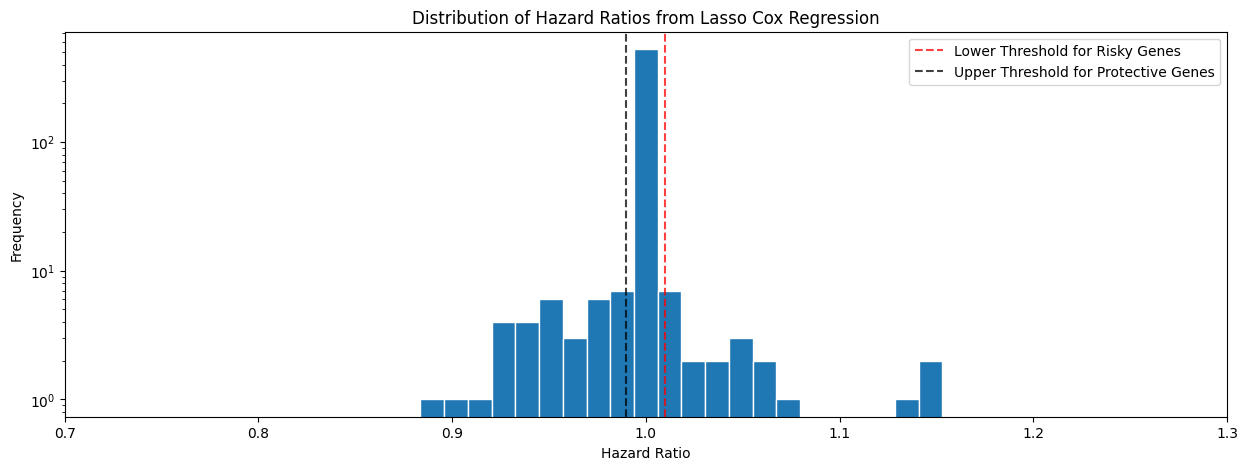

In [23]:
_, axes = plt.subplots(figsize=(15, 5))
cph_lasso.hazard_ratios_.hist(
    bins=np.linspace(0.7, 1.3, 50),
    edgecolor='w',
    grid=False,
    ax=axes
)
axes.axvline(1.01, color='red', linestyle='--', label='Lower Threshold for Risky Genes', alpha=0.75)
axes.axvline(0.99, color='k', linestyle='--', label='Upper Threshold for Protective Genes', alpha=0.75)

axes.set_xlabel('Hazard Ratio')
axes.set_ylabel('Frequency')
axes.set_title('Distribution of Hazard Ratios from Lasso Cox Regression')
axes.set_yscale('log')
axes.legend()
axes.set_xlim([0.7, 1.3]);

In [24]:
threshold = 0.01 # Hazard ratio threshold for selecting genes
# Select genes with hazard ratios +/- threshold from 1

lasso_results_df = cph_lasso.summary
selected_genes_list = lasso_results_df[
    (lasso_results_df['exp(coef)'] > 1 + threshold) |
    (lasso_results_df['exp(coef)'] < 1 - threshold)
    ].index.tolist()

df_selected_genes = df_gene_filt[selected_genes_list]
df_selected_genes.shape

(1226, 46)

Fit an unpenalized CoxPHFitter model with the Lasso filtered genes to determine statistically significant genes

In [25]:
inference_df = df_final = df_clinical[["duration", "event"]].merge(df_selected_genes, left_index=True, right_index=True)

cph_inference = CoxPHFitter()
cph_inference.fit(df_final.round(2), duration_col='duration', event_col='event')

final_results = cph_inference.summary

# Filter for genes with a p-value < 0.05 
significant_genes = final_results[final_results['p'] < 0.05]

print(f"{significant_genes.shape[1]} significant genes found with p-value < 0.05")

11 significant genes found with p-value < 0.05


Most risky genes (i.e., the genes with the highest risk of death)

In [26]:
significant_genes.sort_values(by="coef", ascending=False).head(5)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ENSG00000106809,0.302434,1.353149,0.097151,0.112023,0.492846,1.118538,1.636969,0.0,3.113045,0.001852,9.076952
ENSG00000272398,0.256099,1.291880,0.077659,0.103890,0.408308,1.109478,1.504270,0.0,3.297730,0.000975,10.002756
ENSG00000173335,0.209786,1.233414,0.065789,0.080841,0.338730,1.084198,1.403165,0.0,3.188749,0.001429,9.450883
ENSG00000115221,0.189616,1.208785,0.082406,0.028103,0.351129,1.028501,1.420670,0.0,2.300991,0.021392,5.546774
ENSG00000162366,0.181447,1.198951,0.079882,0.024881,0.338012,1.025194,1.402158,0.0,2.271443,0.023120,5.434702


Most protective genes (i.e., the genes with the lowest risk of death)

In [27]:
significant_genes.sort_values(by="coef", ascending=True).head(5)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ENSG00000135346,-0.273923,0.760390,0.103998,-0.477755,-0.070092,0.620174,0.932308,0.0,-2.633937,0.008440,6.888521
ENSG00000164434,-0.268616,0.764437,0.081122,-0.427611,-0.109621,0.652065,0.896174,0.0,-3.311278,0.000929,10.072487
ENSG00000104368,-0.219895,0.802603,0.091929,-0.400073,-0.039718,0.670271,0.961060,0.0,-2.392016,0.016756,5.899170
ENSG00000197977,-0.208011,0.812198,0.076168,-0.357298,-0.058724,0.699564,0.942967,0.0,-2.730948,0.006315,7.306947
ENSG00000133048,-0.198603,0.819875,0.072614,-0.340925,-0.056281,0.711112,0.945273,0.0,-2.735032,0.006237,7.324836


## Can we predict 5 year Survival Using XGBoost?

Compare the most predictive genes found from the Cox model with the most predictive genes for 5 year survival using XGBoost

In [64]:
landmark_time = 5 # years where we want to evaluate the risk

In [65]:
df_survival = df_lasso[~((df_lasso["duration"]<landmark_time) & (df_lasso["event"]!=1))]
print(f"{df_survival.shape[0]/df_lasso.shape[0]*100:.2f}% of the original cohort had a known {landmark_time}-year outcome and are usable for this analysis.")


30.88% of the original cohort had a known 5-year outcome and are usable for this analysis.


In [66]:
df_survival["survival"] = df_survival["duration"].apply(lambda x: x>5)
df_survival["survival"].value_counts(normalize=True)

/var/folders/wt/5vc39b651nn6m5wm29j25dk80000gn/T/ipykernel_15460/2891837333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survival["survival"] = df_survival["duration"].apply(lambda x: x>5)


survival
True     0.756614
False    0.243386
Name: proportion, dtype: float64

Train an XGBoost model to predict landmark survival based solely on genetic expression

In [67]:
from sklearn.model_selection import KFold
import shap
from xgboost import XGBClassifier

#TODO: fix imbalance issue and check again

# Assuming data_x and data_y are already defined as per your notebook
X = df_survival.drop(columns=['event', 'duration', 'survival'])  # Features
y = df_survival['survival']  # Target variable

# Initialize the model
model = XGBClassifier(eval_metric='logloss')

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store SHAP values for each fold
shap_values_list = []
xgb_accuracy_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    xgb_accuracy_list.append(accuracy)
    # Create a SHAP explainer
    explainer = shap.Explainer(model)
    
    # Calculate SHAP values for the test set
    shap_values = explainer(X_test)
    
    # Store the SHAP values
    shap_values_list.append(shap_values)

print(f"Mean accuracy: {np.mean(xgb_accuracy_list)*100:.2f}%")

Mean accuracy: 76.45%


In [68]:
shap_values = np.concatenate([x.values for x in shap_values_list])

<Axes: xlabel='SHAP value (impact on model output)'>

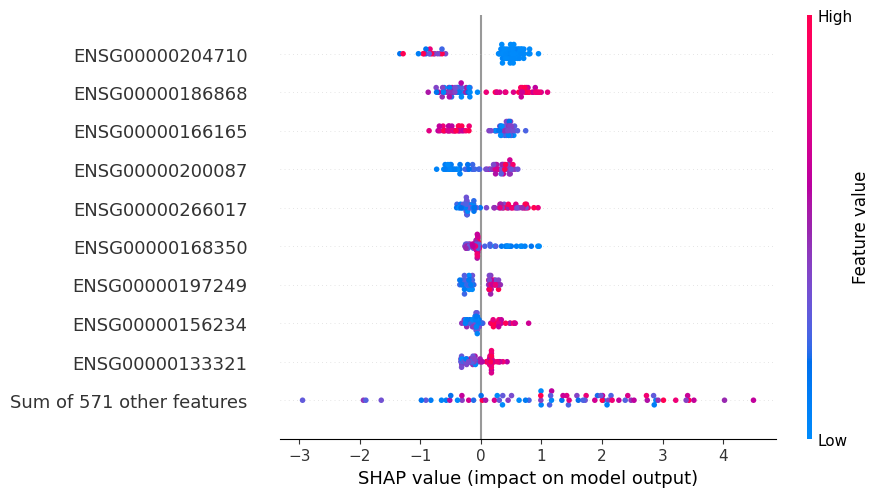

In [69]:
shap.plots.beeswarm(shap_values_list[0], max_display=10, show=False)

In [71]:
significant_genes.sort_values(by="exp(coef)", ascending=False)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
ENSG00000106809,0.302434,1.353149,0.097151,0.112023,0.492846,1.118538,1.636969,0.0,3.113045,0.001852,9.076952
ENSG00000272398,0.256099,1.291880,0.077659,0.103890,0.408308,1.109478,1.504270,0.0,3.297730,0.000975,10.002756
ENSG00000173335,0.209786,1.233414,0.065789,0.080841,0.338730,1.084198,1.403165,0.0,3.188749,0.001429,9.450883
ENSG00000115221,0.189616,1.208785,0.082406,0.028103,0.351129,1.028501,1.420670,0.0,2.300991,0.021392,5.546774
ENSG00000162366,0.181447,1.198951,0.079882,0.024881,0.338012,1.025194,1.402158,0.0,2.271443,0.023120,5.434702
ENSG00000171199,0.168432,1.183448,0.055341,0.059965,0.276898,1.061800,1.319032,0.0,3.043525,0.002338,8.740363
ENSG00000204710,0.166546,1.181218,0.063092,0.042888,0.290203,1.043821,1.336699,0.0,2.639743,0.008297,6.913213
ENSG00000185686,0.135755,1.145401,0.059490,0.019157,0.252352,1.019342,1.287049,0.0,2.281991,0.022490,5.474581
ENSG00000105388,0.122668,1.130509,0.056249,0.012421,0.232915,1.012499,1.262274,0.0,2.180788,0.029199,5.097933


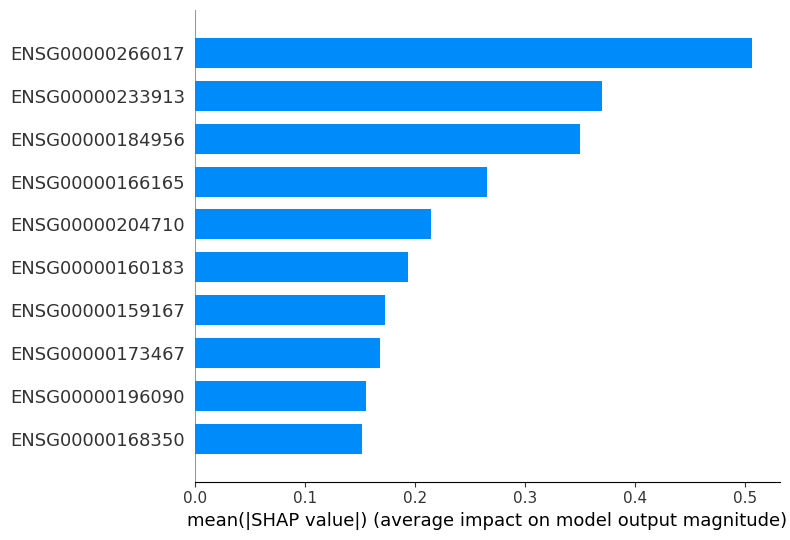

In [61]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

**Problems with this approach**:

**The Censoring Problem**: By excluding patients who were censored before 5 years, we are likely introducing bias. For example, if patients who are sicker are more likely to move away to seek treatment elsewhere (and thus become "lost to follow-up"), we would be systematically removing sicker patients from your dataset, making the model overly optimistic.

**Loss of All Other Time Information**: A patient who dies at 4.9 years is treated exactly the same as a patient who dies at 6 months. The model can't learn that one outcome is much worse than the other. A patient who is alive at 5.1 years is treated exactly the same as a patient who is alive at 20 years. The model doesn't learn about long-term survivorship.
The model is essentially ignoring all the rich data contained in the "survival" dimension.

## Given the Trade-Offs Above, Use Random Survival Forrest Instead

Scikit-Survival can provide the same Kaplan-Meier survival plots as the lifelines package.

(0.0, 1.0)

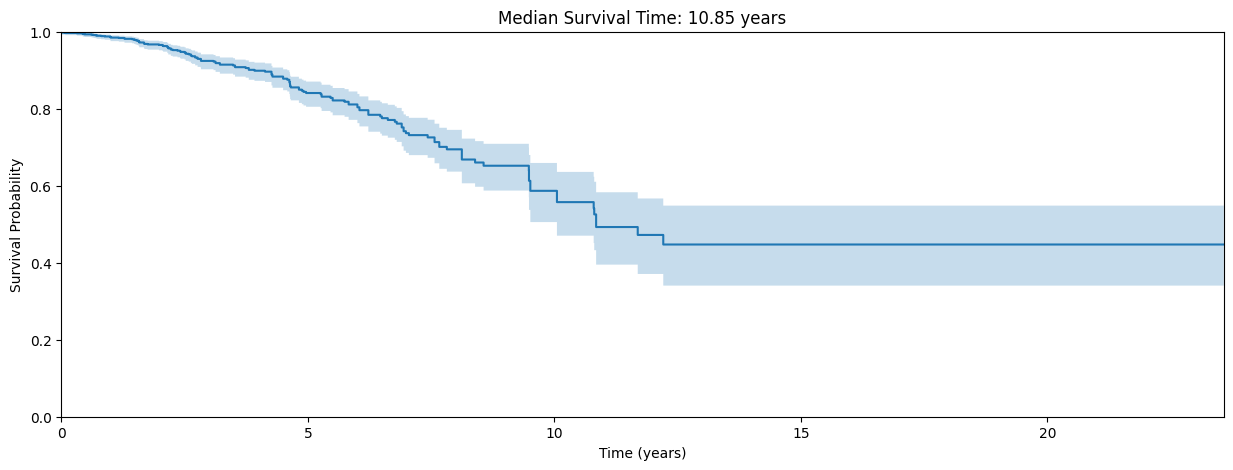

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
     df_clinical["event"].astype(bool), df_clinical["duration"], conf_type="log-log"
)

_, axes = plt.subplots(figsize=(15,5))
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.title(f"Median Survival Time: {kmf.median_survival_time_:.2f} years")
plt.xlabel("Time (years)")
plt.ylabel("Survival Probability")
plt.xlim(0, df_clinical["duration"].max())
plt.ylim(0, 1)